In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.filterwarnings('ignore')
from discretization import discretize, discretize_volume_deviation

In [81]:
df1 = pd.read_csv('../data/E_B02_Sequenz_1.csv', delimiter=';')
df2 = pd.read_csv('../data/E_B02_Sequenz_2.csv', delimiter=';')
df3 = pd.read_csv('../data/E_B02_Sequenz_3.csv', delimiter=';')

df = df1.append(df2).append(df3)
print(len(df), len(df1), len(df2), len(df3))


df.head()

255 87 84 84


,geschwindigkeit,tonlage,schallstaerke
0,87,257,33
1,84,227,33
2,82,231,34
3,79,240,37
4,76,232,41


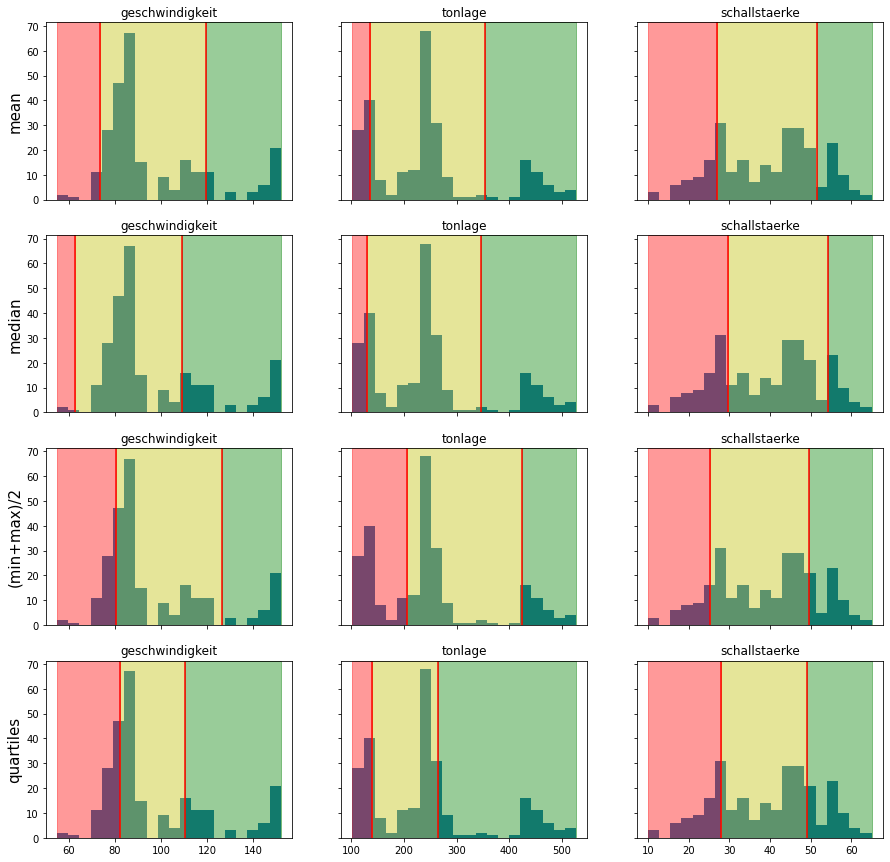

In [4]:

def mean_lower(col):
    return col.mean() - col.std() 

def mean_upper(col):
    return col.mean() + col.std() 

def median_lower(col):
    return col.median() - col.std()

def median_upper(col):
    return col.median() + col.std()

def half_min_max_lower(col):
    return (col.max() + col.min()) / 2 - col.std()

def half_min_max_upper(col):
    return (col.max() + col.min()) / 2 + col.std()

def quartile_lower(col):
    return col.quantile(0.25)

def quartile_upper(col):
    return col.quantile(0.75)


lower_funs = (mean_lower, median_lower, half_min_max_lower, quartile_lower) 
upper_funs = (mean_upper, median_upper, half_min_max_upper, quartile_upper)
fun_names = ("mean", "median", "(min+max)/2", "quartiles")
    
fig, axes = plt.subplots(nrows=len(lower_funs), ncols=3, figsize=(15,15),
                        sharex='col', sharey='row')

for lower_fun, upper_fun, name, row_axes in zip(lower_funs, upper_funs, fun_names, axes):
    
    for col_name, ax in zip(df, row_axes):
        col = df[col_name]

        col.plot.hist(bins=20, ax=ax)
        
        ax.axvline(lower_fun(col), color='r')
        ax.axvline(upper_fun(col), color='r')
        
        ax.axvspan(col.min(), lower_fun(col), alpha=0.4, color='r')
        ax.axvspan(lower_fun(col), upper_fun(col), alpha=0.4, color='y')
        ax.axvspan(upper_fun(col), col.max(), alpha=0.4, color='g')
        ax.set_title(col_name)
        
    row_axes[0].set_ylabel(name, size=15)

In [5]:
for col in df:
    middle = (df[col].min() + df[col].max()) / 2
    print(col, middle - df[col].std(), middle + df[col].std())

geschwindigkeit 80.41449260821402 126.58550739178598
tonlage 205.53426592401945 423.46573407598055
schallstaerke 25.29200256052748 49.70799743947252


In [104]:
df.quantile(0.25)['geschwindigkeit']

82.5

In [106]:
def _stringify(x, lower, upper):
    if x <= lower: return "low"
    if x >= upper: return "high"
    return "normal"

def discretize_using_fixed_borders(df):
    borders = {
        'geschwindigkeit': (80, 126),
        'tonlage': (180, 423),
        'schallstaerke': (25, 49)
    }

    for col in df:
        lower_border, upper_border = borders[col]

        df[col] = df[col].map(lambda x: _stringify(x, lower_border, upper_border))

    return df

def discretize_using_quartiles(df):
    for col in df:
        df[col] = pd.qcut(df[col],
                          q=(0, .25, .75, 1),
                          labels=('low', 'normal', 'high'))
    return df

def discretize_window(window):
    lower_quartiles = df.quantile(0.25)
    upper_quartiles = df.quantile(0.75)
    
    for col in window:
        window[col] = window[col].map(lambda entry: _stringify(entry,
                                                 lower_quartiles[col],
                                                 upper_quartiles[col]))
    return window


discrete_df = discretize_using_quartiles(df.copy())
discrete_df.head()

,geschwindigkeit,tonlage,schallstaerke
0,normal,normal,normal
1,normal,normal,normal
2,low,normal,normal
3,low,normal,normal
4,low,normal,normal


Text(22.200000000000017, 0.5, 'quartiles')

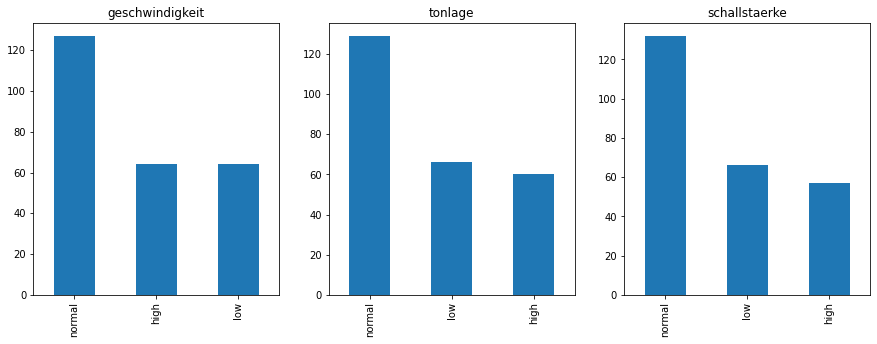

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

for col_name, ax in zip(df, axes):
    col = discrete_df[col_name]

    col.value_counts().plot(kind='bar', ax=ax)

    ax.set_title(col_name)

row_axes[0].set_ylabel(name, size=15)

### Normalization: Portions in Low, Normal, High 

In order to map a windows concrete values to a basic measure we calculate the discrete distribution in the last ten seconds (for each feature: calculating how many of the last then steps were `low`, `normal` or `high`.

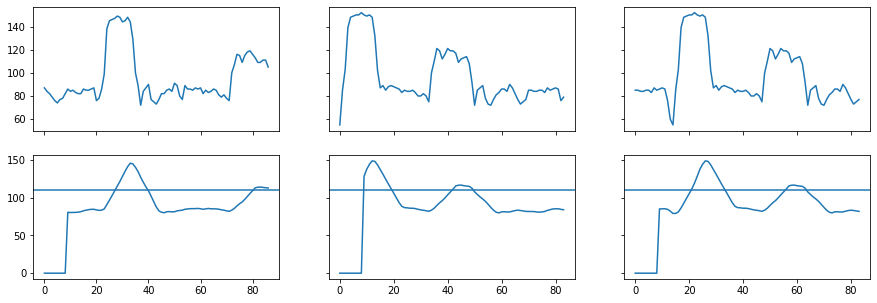

In [108]:
dfs = (df1, df2, df3)
vals = tuple(map(lambda df: df['geschwindigkeit'], dfs))
windows = tuple(map(lambda df: df.rolling(window=10)['geschwindigkeit'],
                   dfs))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5),
                         sharey='row', sharex='col')
val_axes, window_axes = axes
                         
for val, ax in zip(vals, val_axes):
    val.plot(ax=ax)

for window, ax in zip(windows, window_axes):
    window.mean().fillna(0).plot(ax=ax)
    ax.axhline(df['geschwindigkeit'].quantile(0.75))

As an example: The last ten seconds of the first sequence look like they have a comparitively high speed.

In [109]:
last_window = df1[-10:]
window = last_window

In [107]:
discrete_window = discretize_window(window.copy())

dist = {}
for col in discrete_window:
    window_counts = dict(discrete_window[col].value_counts())
    dist[col] = tuple(window_counts.get(level, 0) / len(discrete_window)
                for level in  ('low', 'normal', 'high'))
dist

{'geschwindigkeit': (0.0, 0.3, 0.7),
 'tonlage': (0.0, 0.0, 1.0),
 'schallstaerke': (0.0, 0.8, 0.2)}

This gives us three basic measures:

    # high , low, normal
    mSpeed(A, Ü, W, F) = 0.7, mSpeed(F, E) = 0, mSpeed(Omega) = 0.3
    mPitch(A, Ü, W, F) = 1.0, mPitch(E, T) = 0, mPitch(Omega) = 0
    mIntensity(Ü, W, F) = 0.2, mIntensity(T) = 0,
        mIntensity(Omega) = 0.8

In [104]:
df.quantile(0.25)['geschwindigkeit']

82.5

## Schallstärke: geringe Schwankungen

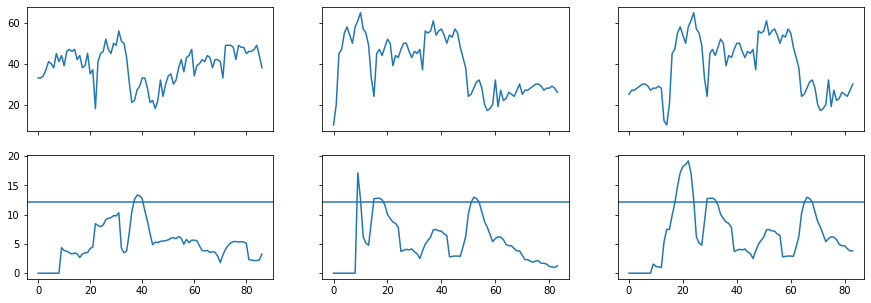

In [8]:
dfs = (df1, df2, df3)
vals = tuple(map(lambda df: df['schallstaerke'], dfs))
windows = tuple(map(lambda df: df.rolling(window=10)['schallstaerke'],
                   dfs))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,5),
                         sharey='row', sharex='col')
val_axes, window_axes = axes
                         
for val, ax in zip(vals, val_axes):
    val.plot(ax=ax)

for window, ax in zip(windows, window_axes):
    window.std().fillna(0).plot(ax=ax)
    ax.axhline(df['schallstaerke'].std())

In [60]:
df['schallstaerke'].std()

12.207997439472523

Scaling the Standard Deviation in a window to between 0 and 1: Fit a `MinMaxScaler` on all windows.

In [87]:
from sklearn.preprocessing import MinMaxScaler

win_stds = df.rolling(window=10)['schallstaerke'].std()
intensity_std_scaler = MinMaxScaler()
intensity_std_scaler.fit(win_stds.to_numpy().reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [96]:
window = df3[12:22]
window['schallstaerke'].std()

18.56789343643125

In [95]:
intensity_std_scaler.transform(window['schallstaerke'].std().reshape(-1,1))

array([[0.96515887]])

Compared to the end of sequence 1:

In [110]:
window = df1[-10:]
window_std = window['schallstaerke'].std()
intensity_std_scaler.transform(window_std.reshape(-1,1))

array([[0.12611002]])

Which gives us a forth basic measure:

    mIntensityStd(T) = 0.126, mIntensityStd(Omega) = (1 - 0.126)